# Introduction

Dans ce notebook, nous allons essayer de mettre en place des modèles de réseaux de neurones récurrents sur les données PM issus de capteurs de la sud 3. Dans ce notebook nous avons essayé des modèles de réseaux récurrents avec plusieurs couches récurrentes avec des données sur de grandes séquences. Les séquences testées de ce notebook ont varié de 24 à 200 points. Egalement le nombre de couches récurrentes testées a varié de 1 à 3 et le nombre de couches Denses en sortie de 1 à 2. Il n'est présenté dans ce notebook que le modèle présentant les meilleurs résultats compte-tenu des paramètres testés.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
DATA_PATH = "../../data/clean/sud3_pm.pkl"
PATIENCE = 25

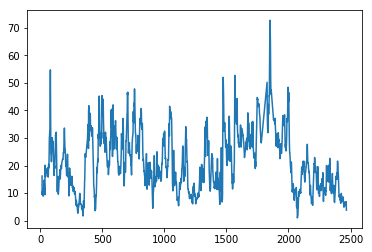

,index,date,ref,PM_6182,PM_6179,PM_617B,PM25_6182,PM25_6179,PM25_617B,rh,t_grad,pressure,temp,pluvio
2458,2458,2017-10-24 00:45:00,6.5,6.1,9.3,9.8,5.8,8.6,8.5,88.3,-0.8,1020.4,15.5,0.0
2459,2459,2017-10-24 01:00:00,6.6,6.6,7.4,10.7,6.3,6.9,9.2,88.7,-0.9,1020.4,15.5,0.0
2460,2460,2017-10-24 01:15:00,5.8,8.5,6.4,13.6,8.0,6.1,11.4,88.7,-0.9,1020.4,15.5,0.0
2461,2461,2017-10-24 01:30:00,5.5,7.9,10.1,14.7,7.5,9.4,12.5,89.0,-0.9,1020.4,15.5,0.0
2462,2462,2017-10-24 01:45:00,6.1,7.2,12.8,11.0,6.9,11.8,9.3,89.0,-0.9,1020.4,15.5,0.0
2463,2463,2017-10-24 02:00:00,5.9,9.3,10.7,11.4,8.7,9.9,9.8,89.2,-0.9,1020.2,15.6,0.0
2464,2464,2017-10-24 02:15:00,6.7,8.4,10.3,12.1,7.8,9.6,10.4,89.3,-0.9,1020.2,15.6,0.0
2465,2465,2017-10-24 02:30:00,6.9,7.1,10.1,9.8,6.7,9.4,8.4,89.1,-0.9,1020.0,15.6,0.0
2466,2466,2017-10-24 02:45:00,5.0,8.2,6.4,8.1,7.9,6.1,6.9,89.0,-0.9,1020.1,15.7,0.0
2467,2467,2017-10-24 03:00:00,3.8,7.5,4.8,7.6,7.2,4.5,6.4,89.0,-0.9,1020.3,15.7,0.0


In [3]:
df = pd.read_pickle(DATA_PATH)
df = df.reset_index()
df = df.dropna()

plt.plot(df["ref"])
plt.show()
df.tail(10)

In [4]:
df.describe()

,index,ref,PM_6182,PM_6179,PM_617B,PM25_6182,PM25_6179,PM25_617B,rh,t_grad,pressure,temp,pluvio
count,2267.000000,2267.000000,2267.000000,2267.000000,2267.000000,2267.000000,2267.000000,2267.000000,2267.000000,2267.000000,2267.000000,2267.000000,2267.000000
mean,1239.796648,21.212086,25.395589,29.926246,36.721835,23.752713,27.815748,31.205514,73.617027,-0.414557,1017.770534,16.697089,0.018747
std,705.400522,10.602717,17.038105,18.893550,23.618640,15.922461,17.544039,20.020547,11.009273,1.829324,5.209971,4.239156,0.124942
min,15.000000,1.000000,1.700000,1.800000,1.300000,1.600000,1.800000,1.100000,42.900000,-3.800000,1003.200000,7.200000,0.000000
25%,639.500000,12.700000,12.600000,15.600000,18.900000,11.800000,14.600000,16.200000,66.800000,-1.700000,1015.800000,14.000000,0.000000
50%,1228.000000,19.500000,20.600000,25.400000,29.700000,19.300000,23.500000,25.200000,76.500000,-0.900000,1018.000000,16.200000,0.000000
75%,1858.500000,28.500000,34.250000,40.900000,52.250000,32.200000,38.100000,44.650000,82.800000,0.200000,1021.100000,19.100000,0.000000
max,2467.000000,72.700000,95.900000,97.700000,118.300000,89.300000,90.400000,98.800000,89.300000,7.600000,1027.100000,30.200000,4.300000


# Pré-traitement

On définit dans un premier des méthodes afin de transformer notre jeu de données en séquences.

In [5]:
def split_dataframe(dataframe, percent):
    nb_rows = int(np.floor(percent * len(dataframe)))
    return dataframe[:nb_rows], dataframe[nb_rows:]

def dataframe_to_xy(df, look_back):
    X, y = [], []
    i = look_back
    while i < len(df):
        sequence = df.iloc[i - look_back:i]
        X.append(np.array(sequence[['PM_6182', 'PM_6179', 'PM_617B', 'PM25_6182', 'PM25_6179', 'PM25_617B', 'temp', 'rh',\
                                 't_grad', 'pressure', 'pluvio']]).reshape(look_back, 1, 11))
        y.append(np.array(df.iloc[i]['ref']))
        i += 1
        if i == len(df):
            break
    X = np.array(X)
    y = np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], X.shape[3]))
    return X, y

df_test, df_train = split_dataframe(df, 0.5) 
df_valid, df_test = split_dataframe(df_test, 0.5)

X_train, y_train = dataframe_to_xy(df_train, 128)
X_valid, y_valid = dataframe_to_xy(df_valid, 128)
X_test, y_test = dataframe_to_xy(df_test, 128)

# Modèles

Nous allons tester 3 modèles récurrents: un modèle récurrent simple (SimpleRNN), un modèle LSTM et un modèle GRU

In [6]:
from keras.layers import SimpleRNN, Dense, LSTM, GRU, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam

early_stopping = EarlyStopping(monitor='val_loss', verbose=1, mode='auto', patience=PATIENCE)

def simple_rnn_model(nb_units, input_dim, loss='mean_squared_error', optimizer=Adam(lr=3e-4)):
    model = Sequential()
    model.add(SimpleRNN(nb_units, activation='tanh', input_shape=input_dim, return_sequences=True))
    model.add(SimpleRNN(nb_units, activation='tanh'))
    model.add(Dense(nb_units, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer=optimizer)
    model.summary()
    return model

def lstm_model(nb_units, input_dim, loss='mean_squared_error', optimizer=Adam(lr=3e-4)):
    model = Sequential()
    model.add(LSTM(nb_units, activation='tanh', input_shape=input_dim, return_sequences=True))
    model.add(LSTM(nb_units, activation='tanh'))
    model.add(Dense(nb_units, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer=optimizer)
    model.summary()
    return model

def gru_model(nb_units, input_dim, loss='mean_squared_error', optimizer=Adam(lr=3e-4)):
    model = Sequential()
    model.add(GRU(nb_units, activation='tanh', input_shape=input_dim, return_sequences=True))
    model.add(GRU(nb_units, activation='tanh'))
    model.add(Dense(nb_units, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer=optimizer)
    model.summary()
    return model

Using TensorFlow backend.


## Simple RNN

### Apprentissage

In [7]:
model = simple_rnn_model(16, X_train.shape[1:])
history = model.fit(X_train, y_train, batch_size=16, epochs=1000, validation_data=(X_valid, y_valid), callbacks=[early_stopping], verbose=1, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 128, 16)           448       
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 16)                528       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 1,265
Trainable params: 1,265
Non-trainable params: 0
_________________________________________________________________
Train on 1006 samples, validate on 438 samples
Epoch 1/1000
1006/1006 [==============================] - 2s 2ms/step - loss: 608.1984 - val_loss: 548.3705
Epoch 2/1000
1006/1006 [==============================] - 2s 2ms/step - loss: 596.4480 - val_loss: 533.7086
Epoch 3/1

### Courbes de résultats pour modèle RNN

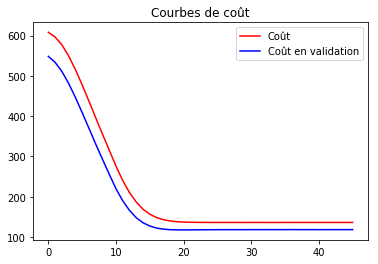

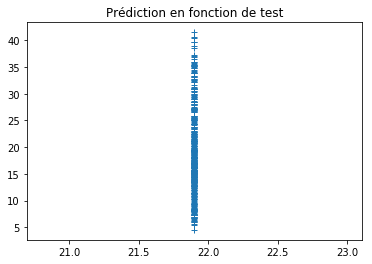

In [8]:
y_pred = model.predict(X_test)
plt.plot(history.history['loss'], 'r-', label="Coût")
plt.plot(history.history['val_loss'], 'b-', label="Coût en validation")
plt.title("Courbes de coût")
plt.legend()
plt.show()

plt.title('y_pred, y_test')

plt.plot(y_pred[:], y_test[:], '+')
plt.title("Prédiction en fonction de test")
plt.show()

## LSTM

### Apprentissage

In [9]:
model = lstm_model(16, X_train.shape[1:])
history = model.fit(X_train, y_train, batch_size=16, epochs=5000, validation_data=(X_valid, y_valid), callbacks=[early_stopping,], verbose=1, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 16)           1792      
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 4,193
Trainable params: 4,193
Non-trainable params: 0
_________________________________________________________________
Train on 1006 samples, validate on 438 samples
Epoch 1/5000
1006/1006 [==============================] - 9s 9ms/step - loss: 612.1613 - val_loss: 552.2237
Epoch 2/5000
1006/1006 [==============================] - 8s 8ms/step - loss: 599.9608 - val_loss: 536.6779
Epoch 3/5

### Courbes de résultats pour modèle LSTM

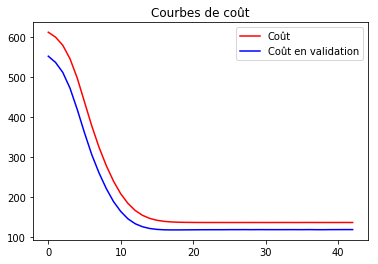

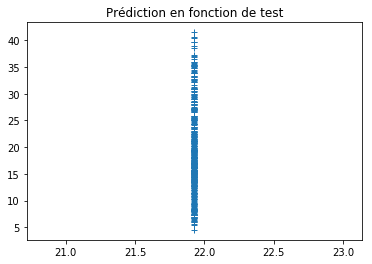

In [10]:
y_pred = model.predict(X_test)
plt.plot(history.history['loss'], 'r-', label="Coût")
plt.plot(history.history['val_loss'], 'b-', label="Coût en validation")
plt.title("Courbes de coût")
plt.legend()
plt.show()

plt.title('y_pred, y_test')

plt.plot(y_pred[:], y_test[:], '+')
plt.title("Prédiction en fonction de test")
plt.show()

## GRU

### Apprentissage

In [11]:
model = gru_model(16, X_train.shape[1:])
history = model.fit(X_train, y_train, batch_size=16, epochs=5000, validation_data=(X_valid, y_valid), callbacks=[early_stopping], verbose=1, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 128, 16)           1344      
_________________________________________________________________
gru_2 (GRU)                  (None, 16)                1584      
_________________________________________________________________
dense_5 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 17        
Total params: 3,217
Trainable params: 3,217
Non-trainable params: 0
_________________________________________________________________
Train on 1006 samples, validate on 438 samples
Epoch 1/5000
1006/1006 [==============================] - 7s 7ms/step - loss: 612.9035 - val_loss: 548.7563
Epoch 2/5000
1006/1006 [==============================] - 7s 7ms/step - loss: 593.3908 - val_loss: 527.5851
Epoch 3/5

### Courbes de résultats pour modèle GRU

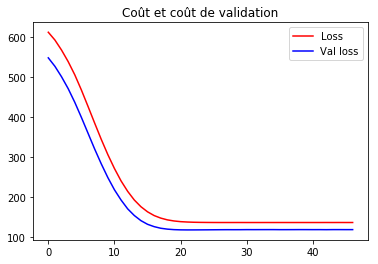

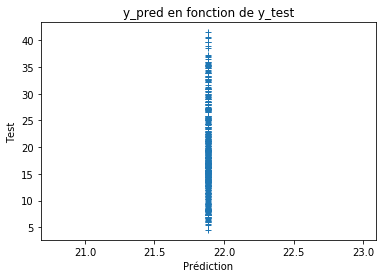

In [12]:
y_pred = model.predict(X_test)
plt.title('Coût et coût de validation')
line1,=plt.plot(history.history['loss'], label="Loss", linestyle='-', color='r')
line2,=plt.plot(history.history['val_loss'], label="Val loss", linestyle='-', color='b')
first_legend = plt.legend(handles=[line1, line2], loc=1)

plt.show()

plt.title('y_pred en fonction de y_test')

plt.plot(y_pred[:], y_test[:], '+')
plt.ylabel('Test')
plt.xlabel('Prédiction')
plt.show()

# Conclusion

Nous avons testé des modèles récurrents avec des séquences de points. Malheureusement les modèles tendent vers la prédiction de la moyenne de la référence. Ce qui a été essayé pour essayer de palier a ce problème est 
  * **look_back** variant de 24 à 200
  * Variation du nombre de couches récurrentes et denses
  * Des batchs sizes variant de 1 à 32
  * L'utilisation comme optimizer d'un SGD avec des petits pas d'apprentissage (10e-6)
  * L'utilisation de Dropout pour régulariser.